In [34]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [1]:
import netCDF4 as nc
import gsw
import pickle as pk
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# load SODA NWA boundary condition file

SODA_file = "/d1/enrique/bdry/NWA_bdry_SODA3.3.1_y2012.nc"
Sds = nc.Dataset(SODA_file)
#Sds.variables.keys()

In [3]:
# pull out salinity and temperature 

temp_south = Sds.variables['temp_south'][:]
temp_east = Sds.variables['temp_east'][:]

salt_south = Sds.variables['salt_south'][:]
salt_east = Sds.variables['salt_east'][:]

#print(temp_south.shape)
#print(temp_east.shape)
#print(salt_south.shape)
#print(salt_east.shape)

In [4]:
# load depth at each NWA grid point

with open('/d1/mkelly/NWA/romsdepth.p', 'rb') as f:
    depth = pk.load(f)

# index BC depths
depth_east = depth[:, 721, :]
depth_south = depth[0, :, :]

# transpose depth to match other variable dims
depth_south=np.transpose(depth_south)
depth_east=np.transpose(depth_east)

#print(depth_south.shape)

# pickle BC depth to use later
with open('BC_depth.p', 'wb') as f:
    pk.dump([depth_south, depth_east], f)

In [5]:
# get latitude and longitude coordinates from NWA grid file
grd_file = "/d1/mkelly/NWA/NWA_grd.nc"
grdds = nc.Dataset(grd_file)

lat = grdds.variables['lat_rho'][:]
lon = grdds.variables['lon_rho'][:]

#print(lon.shape)

# index BC coords
lat_south = lat[0, :]
lon_south = lon[0, :]

lat_east = lat[:, 721]
lon_east = lon[:, 721]

#print(lon_south.shape)
#print(lat_east.shape)

# repeat lat and lon at all 40 depth levels
lon_south = np.tile(lon_south, (40, 1))
lat_south = np.tile(lat_south, (40, 1))

lon_east = np.tile(lon_east, (40, 1))
lat_east = np.tile(lat_east, (40, 1))

# pickle BC coords
with open('BC_coords.p', 'wb') as f:
    pk.dump([lon_south, lon_east, lat_south, lat_east], f)

#print(lon_south.shape)
#print(lat_south.shape)

In [6]:
# pull out one time step

salt_south1 = salt_south[0, :, :]
salt_east1 = salt_east[0, :, :]

temp_south1 = temp_south[0, :, :]
temp_east1 = temp_east[0, :, :]

#print(salt_south1.shape)
#print(temp_south1.shape)

# will need to do this in a loop to calculate all time steps

# convert from potential to absolute temperature

In [7]:
# calculate absolute salinity
# SA_south = gsw.SA_from_SP(SP, p, lon, lat)

SA_south = gsw.SA_from_SP(salt_south1, depth_south, lon_south, lat_south)
SA_east = gsw.SA_from_SP(salt_east1, depth_east, lon_east, lat_east)

print(SA_south.shape)

(40, 722)


In [9]:
# attempting loop time steps
#SA_south_time=gsw.SA_from_SP(salt_south[0, :, :], depth_south, lon_south, lat_south)

#SA_south=[]
#SA_south=np.array(SA_south)

#for i in range(72):
#    SA_south[:, :, i] = gsw.SA_from_SP(salt_south[i, :, :], depth_south, lon_south, lat_south)
    
    #SA_south_time=np.stack((SA_south_time, SA_south), axis=2)
    
#print(SA_south_time.shape)

# you can stack 3 things that are the same shape
#SA_south0 = gsw.SA_from_SP(salt_south[0, :, :], depth_south, lon_south, lat_south)
#SA_south1 = gsw.SA_from_SP(salt_south[1, :, :], depth_south, lon_south, lat_south)
#SA_south2 = gsw.SA_from_SP(salt_south[2, :, :], depth_south, lon_south, lat_south)

#SA_south_time = np.stack((SA_south0,SA_south1,SA_south2), axis=2)

#SA_south_time.shape

# but can't if the shape is different, even if it's the dim you're stacking on

#SA_south0 = gsw.SA_from_SP(salt_south[0, :, :], depth_south, lon_south, lat_south)
#SA_south1 = gsw.SA_from_SP(salt_south[1, :, :], depth_south, lon_south, lat_south)
#SA_south2 = gsw.SA_from_SP(salt_south[2, :, :], depth_south, lon_south, lat_south)

#SA_south01 = np.stack((SA_south0,SA_south1), axis=2)

#SA_south_time = np.stack((SA_south01, SA_south2), axis=2)

#SA_south_time.shape

In [10]:
# convert potential to conservative temperature

CT_south = gsw.CT_from_pt(SA_south, temp_south1)
CT_east = gsw.CT_from_pt(SA_east, temp_east1)

In [11]:
# convert conservative to in-situ temperature

ist_south = gsw.t_from_CT(SA_south, CT_south, depth_south)
ist_east = gsw.t_from_CT(SA_east, CT_east, depth_east)

In [12]:
# MLR physical inputs are practical salinity and in situ temp
# pickle physical inputs
with open('SODA_inputs.p', 'wb') as f:
    pk.dump([salt_south1, salt_east1, ist_south, ist_east], f)

# Plot physical MLR inputs to check results

Text(0.5, 1.0, 'practical salinity east')

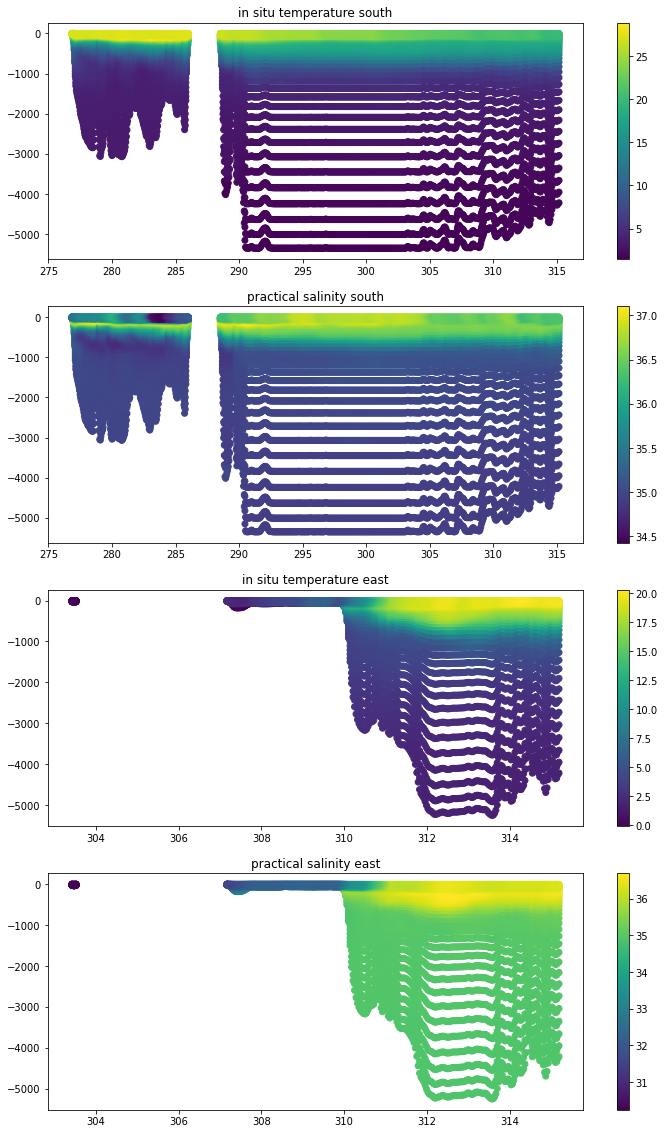

In [13]:
# combine plots as subplots
fig = plt.figure(figsize=(12,20))

ax = fig.add_subplot(411)
plt.scatter(lon_south, depth_south, marker='o', c=ist_south)
plt.colorbar()
plt.title("in situ temperature south")

ax = fig.add_subplot(412)
plt.scatter(lon_south, depth_south, marker='o', c=salt_south1)
plt.colorbar()
plt.title("practical salinity south")

ax = fig.add_subplot(413)
plt.scatter(lon_east, depth_east, marker='o', c=ist_east)
plt.colorbar()
plt.title("in situ temperature east")

ax=fig.add_subplot(414)
plt.scatter(lon_east, depth_east, marker='o', c=salt_east1)
plt.colorbar()
plt.title("practical salinity east")